In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from datetime import datetime
import NSMap as ns
from matplotlib.patches import ConnectionPatch
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as colors

# Analysis of Newport Line Dataset

Here we assess the nonstationarity of time series of several species of plankton which were subject to an extreme heatwave event in 2014-2016. Measurements were taken very irregularly, so instead of using the raw time series, we average all observations taken within a given month. Only a handful of months had no observations - these were left as null.

In [2]:
# Import the data using Pandas
filename = "../datasets/newport/Copepod_Cladoceran_Oikopleura_densities_NH05_1996-present.csv"
data = pd.read_csv(filename, encoding="utf-8")

In [3]:
# Construct the t time series, which it is identical for all species
dates = [(datetime.strptime(m, "%m/%d/%Y")).date() for m in data["SampleDate"].unique()]
months = [m.date() for m in pd.date_range("1996-5-1","2022-4-1", freq='MS')]

# Must create a null time series which is 0 during all months
# where there was at least one observation and NULL otherwise
time_series_default = np.array([0 if np.any([date.year == month.year and date.month == month.month for date in dates])
                         else np.nan 
                         for month in months])

n_years = (months[-1] - months[0]).days / 365
t = np.linspace(0,1,num=len(months))

In [4]:
def get_species_series(species_name, life_history_stage):
    
    species_df = data.query('GenusSpecies == ["{}"] and LifeHistoryStage == ["{}"]'.format(species_name, life_history_stage))
    species_dates = [(datetime.strptime(m, "%m/%d/%Y")).date() for m in species_df["SampleDate"].to_numpy()]
    species_abundances = species_df["Sum(Density (#/m3)"].to_numpy()
    
    ts = time_series_default.copy()
    
    for i in range(ts.shape[0]):
        month = months[i]
        valid_species = np.array([date.year == month.year and date.month == month.month for date in species_dates])
        
        if np.any(valid_species):
            abundance = np.mean(species_abundances[valid_species])
            ts[i] = abundance
        
    return ts

def get_species_aggregate_series(species_name):
    life_stages = pd.unique(data.query('GenusSpecies == ["{}"]'.format(species_name))["LifeHistoryStage"])
    
    time_series = np.zeros(312)
    for life_stage in life_stages:
        time_series += get_species_series(species_name, life_stage)
    
    return time_series

# Determine Most Populous Species

In [5]:
all_genus_species = data["GenusSpecies"].drop_duplicates()
species_dict = dict()
species_agg_dict = dict()

for gs in all_genus_species:
    ts = get_species_aggregate_series(gs)
    total = np.sum(ts, where = ~np.isnan(ts))
    
    species_dict[total] = (gs, ts)
    species_agg_dict[gs] = ts
    
species_time_series_sorted = [species_dict[x] for x in sorted(species_dict, reverse = True)]
species_ordered_by_abundance = [x[0] for x in species_time_series_sorted]

# species_ordered_by_abundance contains the species names in decreasing order of abundance 
# species_agg_dict maps the species name to the time series of every life stage aggregated together

# Ensure Life-Stages are Lag-Uncorrelated
To aggregate several life stages of these species, we first check that one life-stage is not merely a lagged copy of another (like if the number of adults was simply the number of larva a year ago). If a correlation like this occurs, then a single time series should be taken as representation of the whole population instead of an aggregate.

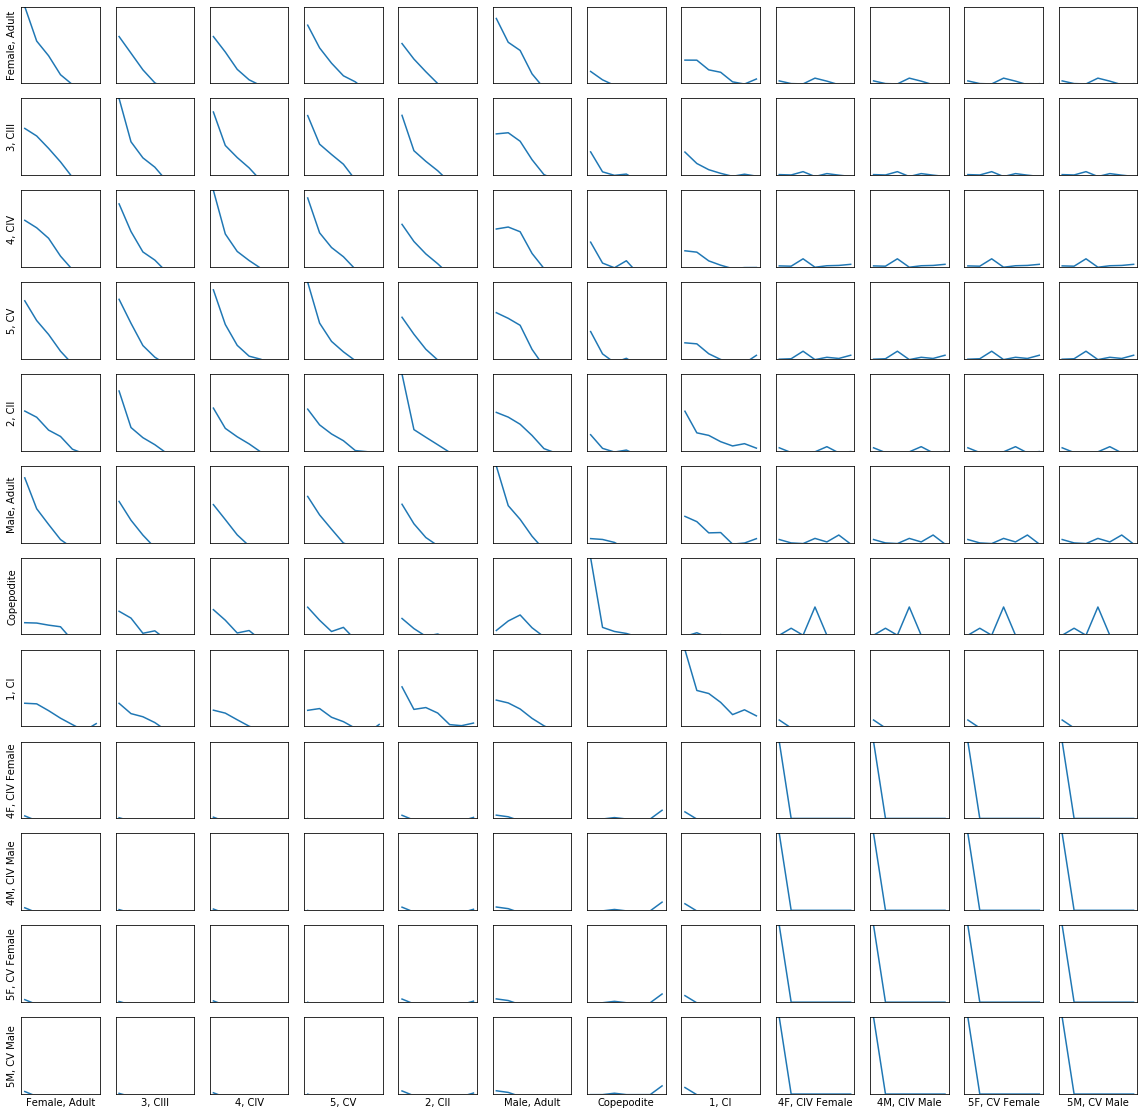

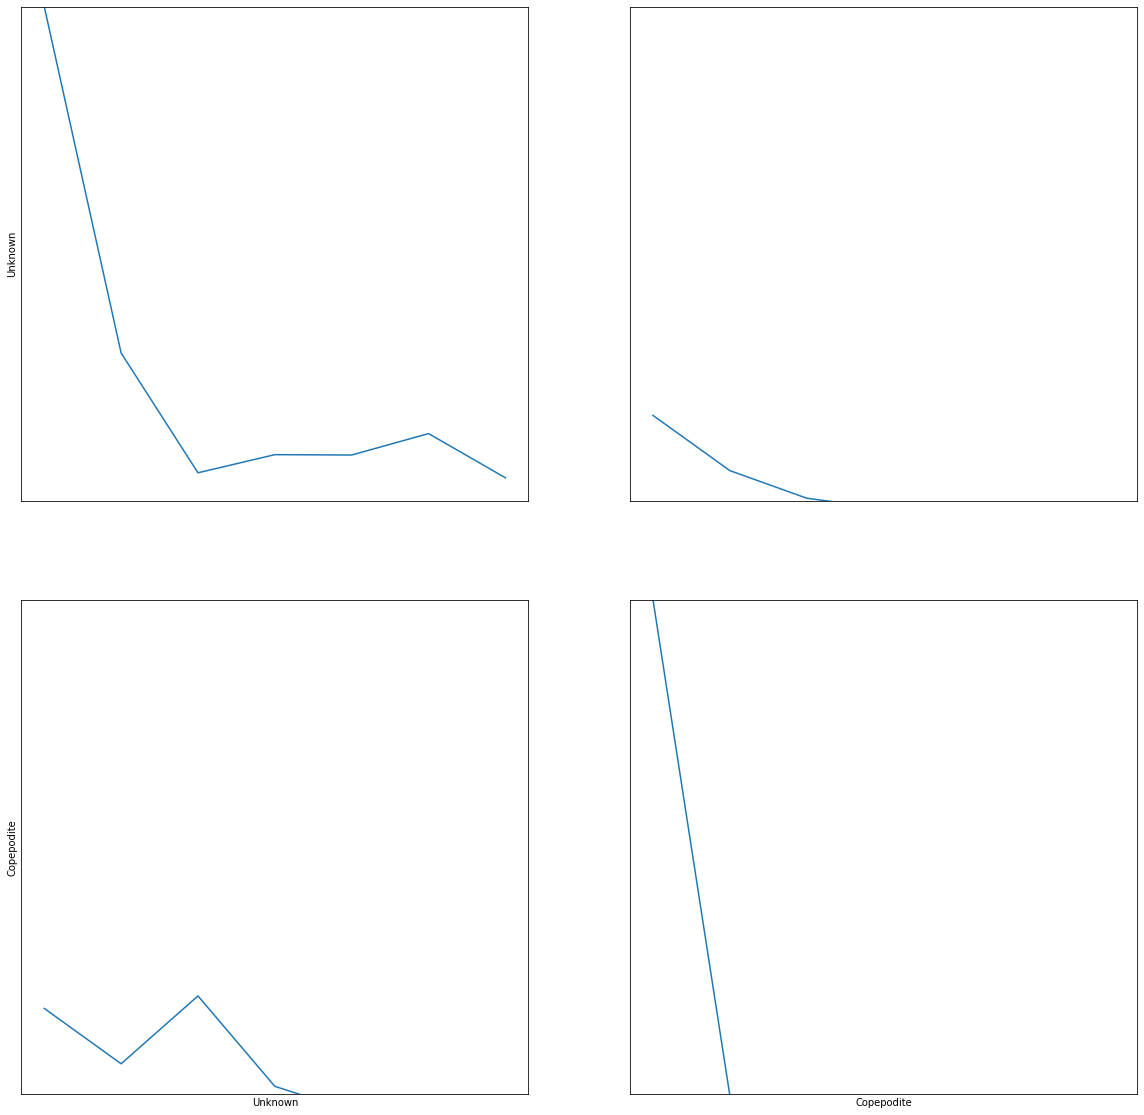

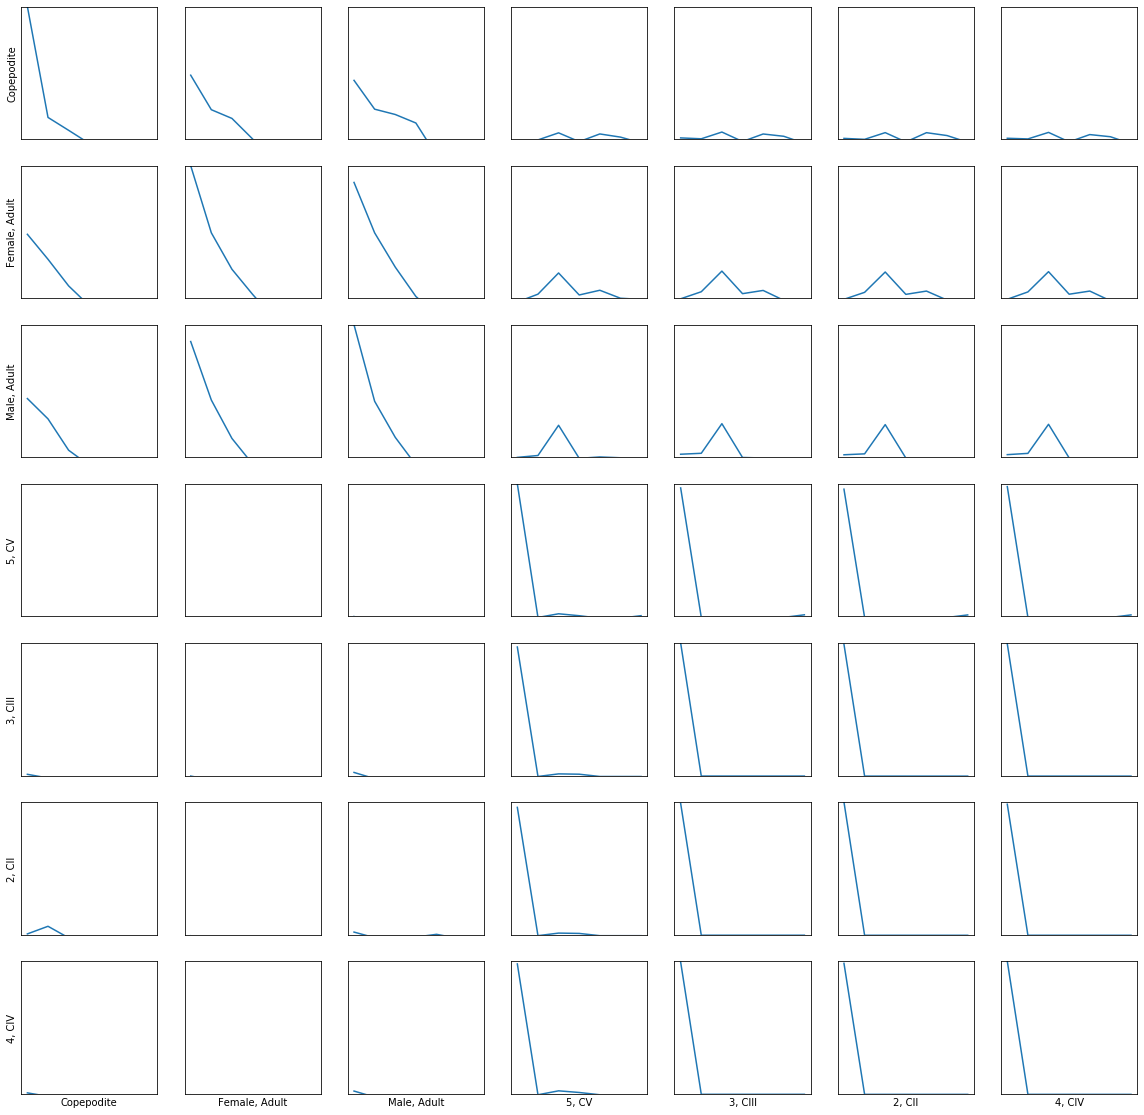

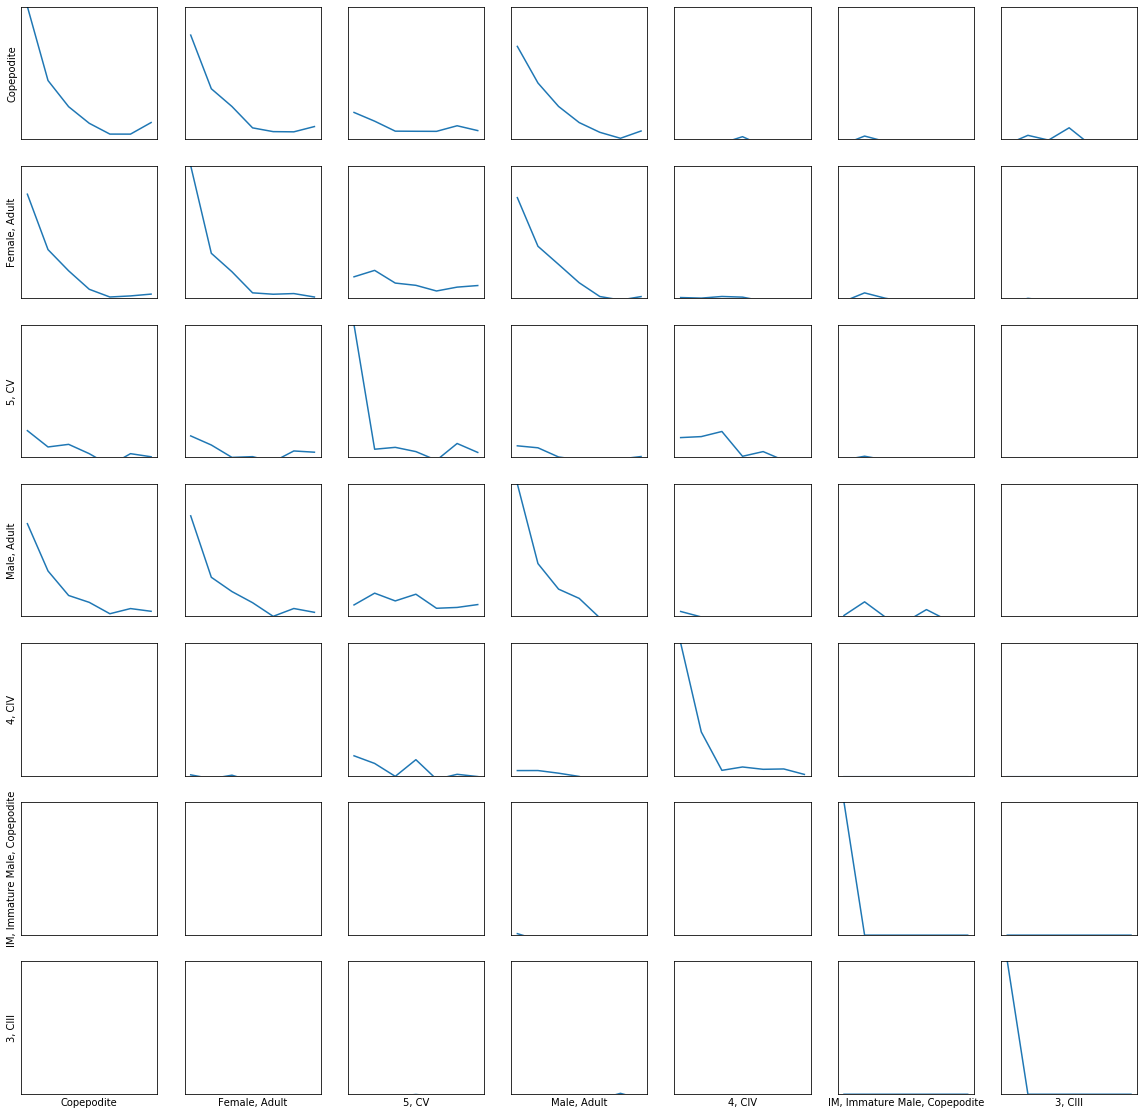

In [6]:
top_4 = species_ordered_by_abundance[:4]
lags = np.arange(7)

for species in top_4:
    life_stages = data.query('GenusSpecies == ["{}"]'.format(species))["LifeHistoryStage"].drop_duplicates().to_numpy()
    fig, ax = plt.subplots(len(life_stages), len(life_stages),figsize=(20,20))
    for i, s1 in enumerate(life_stages):
        for j, s2 in enumerate(life_stages):
            series1 = get_species_series(species, s1)
            series2 = get_species_series(species, s2)
            series1 = series1[~np.isnan(series1)]
            series2 = series2[~np.isnan(series2)]
            
            corr = np.array([np.corrcoef(series1[l:], series2[:-l])[0,1] 
                             if l > 0 else 
                             np.corrcoef(series1, series2)[0,1]
                                 for l in lags])
            
            ax[i,j].plot(lags, corr)
            ax[i,j].set_ylim([0,1])
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                ax[i,j].set_ylabel(s1)
            if i == len(life_stages) - 1:
                ax[i,j].set_xlabel(s2)
            
    # fig.set_title(f"Lag vs correlation coefficient for {species}")
    # plt.savefig(f"../Figures/newport_lags_of_life_stages/{species}_life_stage_lags.png",dpi=600)

Analysis: In general, it does appear that a lagged version of a young life stage is most correlated with a lagged copy of a later life stage. However, the correlation is at most 0.3, which is not strong enough to disallow aggregation.

# Tau Determination

In [9]:
""" Uncomment this code to rerun
h = 0
E_max = 6
taus = np.arange(1,7)
r_sqrd_table = np.zeros((len(taus), 4))

for i, species in enumerate(species_ordered_by_abundance[:4]):
    ts = standardize(np.sqrt(get_species_aggregate_series(species)))

    r_sqrds = [get_delta_agg(ts, E_max, tau=tau,
                             return_forecast_skill=True)[2] 
                   for tau in taus]
    r_sqrd_table[:, i] = r_sqrds

np.savetxt("../results/newport_multiwindow/newport_rsqrd_vs_tau.csv", r_sqrd_table, delimiter=",")
"""

'\nh = 0\nE_max = 6\ntaus = np.arange(1,7)\nr_sqrd_table = np.zeros((len(taus), 4))\n\nfor i, species in enumerate(species_ordered_by_abundance[:4]):\n    ts = standardize(np.sqrt(get_species_aggregate_series(species)))\n\n    r_sqrds = [get_delta_agg(ts, E_max-1, tau=tau, \n                             horizon = tau - h,\n                             return_forecast_skill=True)[2] \n                   for tau in taus]\n    r_sqrd_table[:, i] = r_sqrds\n'

In [10]:
# or don't rerun the above block and just use these precomputed values
r_sqrd_table = np.loadtxt("../results/newport_multiwindow/newport_rsqrd_vs_tau.csv", delimiter=",")

In [11]:
# Check Autocorrelation
taus = np.arange(1,7)
autocorr_table = np.zeros((len(taus), 4))

for i, species_label in enumerate(species_ordered_by_abundance[:4]):
    ts_no_NA = ts[~np.isnan(ts)]
    ts = ns.standardize(np.sqrt(get_species_aggregate_series(species_label)))
    autocorr_table[:,i] = np.array([np.corrcoef(ts_no_NA[tau:], ts_no_NA[:-tau])[0,1]
                                      for tau in taus])

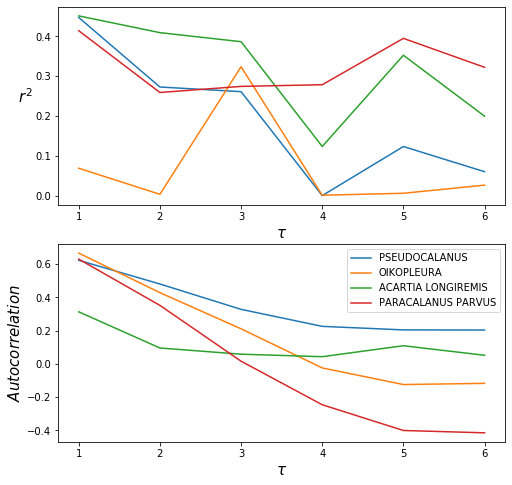

In [13]:
fig, ax = plt.subplots(2, figsize=(8,8))
for i, species_label in enumerate(species_ordered_by_abundance[:4]):
    ax[0].plot(taus, r_sqrd_table[:,i], label=species_label)
    
for i, species_label in enumerate(species_ordered_by_abundance[:4]):
    ax[1].plot(taus, autocorr_table[:,i], label=species_label)

ax[0].set_ylabel(r"$r^2$", fontsize = 15, rotation = 0, labelpad=10)
ax[0].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)

ax[1].set_xlabel(r"$\tau$", fontsize = 15, rotation = 0)
ax[1].set_ylabel(r"$Auto correlation$", fontsize = 15, rotation = 90)

plt.legend()

Final choice is tau = 3 across all series as autocorrelations diminishes for all series while retaining solid forecast skill across the board. Note that the strongly negative autocorrelation for Paracalanus Parvus at high lags is as bad as positive autocorrelation.

# Effect of Time Window on Pseudocalanus
The point of this experiment is to determine the impact of time series window on our assessment of nonstationarity. We conjecture that at intermediate time series lengths we will get the most nonstationarity positives. To test this, we assess nonstationarity for all subsequences of the original time series with length a multiple of 12, and starting index is a multiple of 12.

In [28]:
def drawBracket(start_year, length, ax):
    start_index = start_year - 1996
    length_index = 26 - length
    ax.plot(np.array([start_index, start_index + length ]),
            np.ones(2)*length_index, c="black")
    
# Convert the delta values for each subseries into a square matrix
# which is plotted using matplotlib's imshow.
def makeHeatMapNewport(results):
    nonstationarityHeatMap = np.zeros((25,25)) * np.nan
    for l, o, d, t, r in results:
        i_length = 24-(int(l/12) - 2)
        i_offset = int(o/12)
        nonstationarityHeatMap[i_length, i_offset] = d
    return nonstationarityHeatMap

def makeFigureNewport(nonstationarityHeatMap, ts, name, ax):
    name_to_fig_title = {'Oikopleura' : 'Figure_S12',
                         'Acartia Longiremis' : 'Figure_S13',
                         'Paracalanus Parvus' : 'Figure_S14'}
    
    im = ax.imshow(np.log(nonstationarityHeatMap[:-3]+1), cmap=custom_cmap)
    ax.set_xticks(np.arange(0,26+1,step=2))
    ax.set_xlim(-1.08,27.7)

    ax.set_ylabel("Time series length (years)",fontsize=15)
    ax.set_yticks(np.arange(-1,22+1))
    ax.set_yticklabels(np.flip(np.hstack([np.arange(4,25+1)+1,""])))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = plt.colorbar(im, cax=cax)
    cb.set_label(r"$\log(\overline{\delta}+1)$",fontsize=15)

    axTS = divider.append_axes('bottom', size='30%', pad=0.1)

    axTS.plot(np.linspace(1996.264,2022.335,num=312), ts,c="dodgerblue")
    axTS.set_xticks(np.arange(1996,2022+1,step=2))
    axTS.set_yticks([])
    axTS.set_ylabel(species_label[index], fontsize= 12, style='italic')
    axTS.set_xlabel("Start year",fontsize=15)

    plt.savefig(f"../PDF_figures_tables/newport_multiwindow/{name_to_fig_title[name]}.pdf", format="pdf", bbox_inches="tight")

In [16]:
# Compute the nonstationarity of windows of each series

E_max = 5
tau = 3

for index, species in enumerate(species_ordered_by_abundance[:4]):
    ts = ns.standardize(np.sqrt(get_species_aggregate_series(species)))
    
    maxLen = ts.shape[0]
    lengths = np.arange(24,maxLen+1,step=12)
    
    n_rows = 325
    # length, starting index, delta, theta, r_sqrd
    results = np.zeros((n_rows, 5))
    tally = 0

    for length in lengths:
        for start in np.arange(0, maxLen - length+1, step=12):
            ts_chunk = ts[start:length+start]
            try:
                delta, theta, r_sqrd = get_delta_agg(ts_chunk, E_max-1, tau=tau, return_forecast_skill=True)
            except:
                delta, theta, r_sqrd = (0,0,0)
            delta, theta, r_sqrd = get_delta_agg(ts_chunk, E_max-1, tau=tau, return_forecast_skill=True)
            results[tally] = np.array([length, start, delta, theta, r_sqrd])
            tally += 1
    
    np.savetxt(f"../results/newport_multiwindow/{species}_time_window.csv",results, fmt="%i,%i,%0.5f,%0.5f,%0.5f")

325
325
325
325


In [29]:
# Create custom color map
orange_rgba = colors.to_rgba("orange")
dodgerblue_rgba = colors.to_rgba("dodgerblue")
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [dodgerblue_rgba, orange_rgba]) 

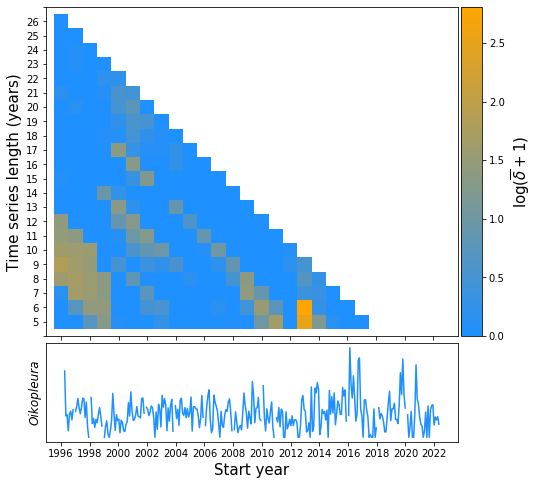

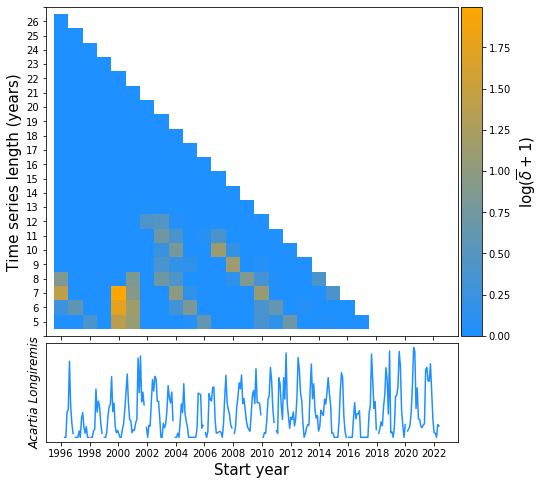

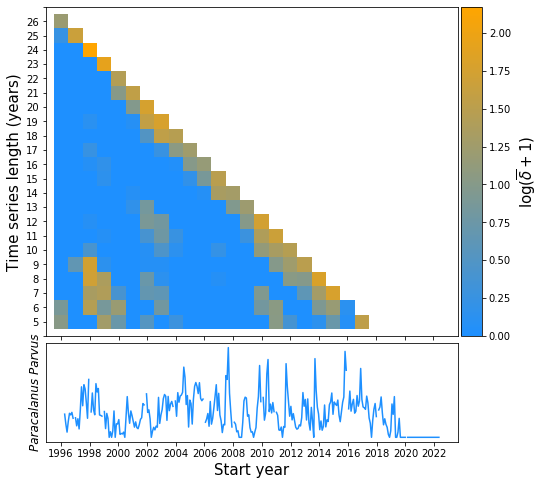

In [30]:
# Produce the plots for each series
for index, species in zip([1,2,3], species_ordered_by_abundance[1:4]):
    fig, ax = plt.subplots(1,figsize=(8,8))
    species_list = ['Pseudocalanus', 'Oikopleura', 'Acartia Longiremis', 'Paracalanus Parvus']

    results = np.loadtxt(f"../results/newport_multiwindow/{species}_time_window.csv", delimiter=",")
    lengths = np.unique(results[:,0])
    
    ts = ns.standardize(np.sqrt(get_species_aggregate_series(species)))
    nonstationarityHeatMap = makeHeatMapNewport(results)
    makeFigureNewport(nonstationarityHeatMap, ts, species_list[index], ax)